<a href="https://colab.research.google.com/github/chenwei-xiao/IML2020/blob/main/task4/IML4_Chenwei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project 4: Prediction of photo similarity (Transfer learning)
# Task: The photos of food and triplets are provided to train a model that can predict the similarity of taste of 3 food.
# (x,x+,x-) => 1; (x,x-,x+) => 0
# if x is more similar to x+ then we assign it to 1 or we assign to 0.


# Author: Chenwei Xiao

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import numpy as np
from keras.preprocessing import image
from keras.applications import resnet50
import os

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
#Load the ResNet50 model as out pre-trained model
resnet_model = resnet50.ResNet50(include_top=False,weights='imagenet',pooling='avg')

In [4]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
img_path = './drive/MyDrive/Colab Notebooks/food/00000.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = resnet50.preprocess_input(img_data)

In [6]:
img_feature = resnet_model.predict(img_data)

In [7]:
img_feature.shape

(1, 2048)

In [8]:
img_dir = './drive/MyDrive/Colab Notebooks/food'
filenames = os.listdir(img_dir)

In [9]:
len(filenames)

10000

In [10]:
filenames.sort()

In [11]:
filenames[0:10]

['00000.jpg',
 '00001.jpg',
 '00002.jpg',
 '00003.jpg',
 '00004.jpg',
 '00005.jpg',
 '00006.jpg',
 '00007.jpg',
 '00008.jpg',
 '00009.jpg']

In [12]:
resnet_feature_list = []
 
for i, fname in enumerate(filenames):
    # process the files under the directory
    
    img = image.load_img(os.path.join(img_dir, fname), target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = resnet50.preprocess_input(img_data)

    resnet_feature = resnet_model.predict(img_data)
    resnet_feature_np = np.array(resnet_feature)
    resnet_feature_list.append(resnet_feature_np)
        
resnet_feature_list_np = np.array(resnet_feature_list)

In [13]:
resnet_feature_list_np.shape

(10000, 1, 2048)

In [15]:
np.save(file='./drive/MyDrive/Colab Notebooks/resnet_feature_list_np.npy',arr = resnet_feature_list_np)

In [7]:
train_data = np.load('./drive/MyDrive/Colab Notebooks/resnet_feature_list_np.npy')

In [8]:
train_data.shape

(10000, 1, 2048)

In [9]:
train_triplets = np.loadtxt('./drive/MyDrive/Colab Notebooks/train_triplets.txt')

In [10]:
train_triplets = train_triplets.astype(int)

In [27]:
train_triplets.shape

(59515, 3)

In [11]:
train_X1 = np.concatenate((train_data[train_triplets[:,0],0,],train_data[train_triplets[:,1],0,],train_data[train_triplets[:,2],0,]),axis = 1)

In [12]:
train_X1.shape

(59515, 6144)

In [13]:
train_X0 = np.concatenate((train_data[train_triplets[:,0],0,],train_data[train_triplets[:,2],0,],train_data[train_triplets[:,1],0,]),axis = 1)

In [14]:
train_X0.shape

(59515, 6144)

In [15]:
y = np.concatenate((np.repeat(1,59515),np.repeat(0,59515)))

In [16]:
train_X = np.concatenate((train_X1,train_X0))

In [17]:
print(train_X.shape)
y.shape

(119030, 6144)


(119030,)

In [ ]:
# Shuffle and split the training set into train and test dataset.

In [18]:
X, y = shuffle(train_X, y, random_state=0)

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=42)

In [20]:
del X,y,train_X0,train_X1,train_X

In [21]:
print(X_train.shape)
print(X_test.shape)

(95224, 6144)
(23806, 6144)


In [22]:
model = keras.models.Sequential()

In [23]:
model.add(layers.Dense(512, input_dim=6144, activation='relu'))
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [26]:
mc = keras.callbacks.ModelCheckpoint('./drive/MyDrive/Colab Notebooks/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [27]:
history = model.fit(X_train, y_train, validation_split=0.2, 
                    batch_size = 512,
          epochs=500, verbose=1, callbacks=[es, mc])

Epoch 1/500
149/149 - 26s - loss: 0.7803 - accuracy: 0.5148 - val_loss: 0.6810 - val_accuracy: 0.5773

Epoch 00001: val_accuracy improved from -inf to 0.57732, saving model to ./drive/MyDrive/Colab Notebooks/best_model.h5
Epoch 2/500
149/149 - 24s - loss: 0.6382 - accuracy: 0.6175 - val_loss: 0.5758 - val_accuracy: 0.6957

Epoch 00002: val_accuracy improved from 0.57732 to 0.69572, saving model to ./drive/MyDrive/Colab Notebooks/best_model.h5
Epoch 3/500
149/149 - 24s - loss: 0.5785 - accuracy: 0.6874 - val_loss: 0.5507 - val_accuracy: 0.7121

Epoch 00003: val_accuracy improved from 0.69572 to 0.71205, saving model to ./drive/MyDrive/Colab Notebooks/best_model.h5
Epoch 4/500
149/149 - 24s - loss: 0.5487 - accuracy: 0.7118 - val_loss: 0.5429 - val_accuracy: 0.7154

Epoch 00004: val_accuracy improved from 0.71205 to 0.71541, saving model to ./drive/MyDrive/Colab Notebooks/best_model.h5
Epoch 5/500
149/149 - 25s - loss: 0.5273 - accuracy: 0.7286 - val_loss: 0.5170 - val_accuracy: 0.7392



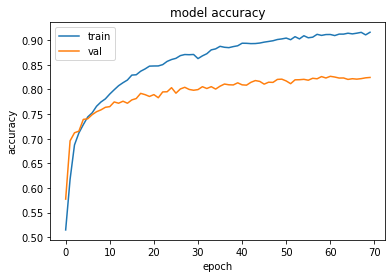

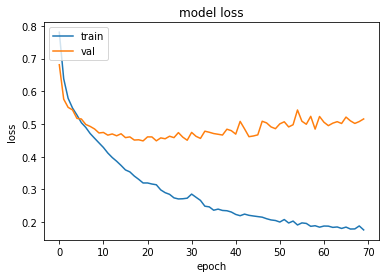

In [36]:
# plot history
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# load best model
saved_model = keras.models.load_model('./drive/MyDrive/Colab Notebooks/best_model.h5')

In [32]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3146240   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,212,033
Trainable params: 3,212,033
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Use our best model to predict and evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.941, Test: 0.826
